In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score


# Import the relevant models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
rw = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-red.csv', sep=';')

In [2]:
rw['quality_label'] = rw['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
rw['quality_label'] = pd.Categorical(rw['quality_label'],
categories=['low', 'medium', 'high'])

In [3]:
le = LabelEncoder()
rw['encoded_quality_label'] = le.fit_transform(rw['quality_label'])  


In [4]:
# Swap 0 for 3 to make the order make sense from low to high
rw['encoded_quality_label'].replace(0,3,inplace=True)

In [5]:
rw.drop(['quality_label'], axis=1, inplace=True)
rw.drop(['quality'], axis=1, inplace=True)

## Create column-vector for quality_label (y)

In [15]:
y_rw_quality = rw.encoded_quality_label
display(y_rw_quality.head())
display(y_rw_quality.shape)

0    1
1    1
2    1
3    2
4    1
Name: encoded_quality_label, dtype: int32

(1599,)

## Select the features to use as inputs

In [14]:
rw_select = rw[['alcohol', 'volatile acidity', 'sulphates', 'citric acid']]
display(rw_select.head())

,alcohol,volatile acidity,sulphates,citric acid
0,9.4,0.70,0.56,0.00
1,9.8,0.88,0.68,0.00
2,9.8,0.76,0.65,0.04
3,9.8,0.28,0.58,0.56
4,9.4,0.70,0.56,0.00


## Split into train and test data

In [16]:
rw_features_train, rw_features_test, rw_quality_train, rw_quality_test = train_test_split(rw_select,y_rw_quality,test_size=0.2, random_state=19)

## Scale wine features to even out their impact on the model

In [17]:

# Also try different methods of normalization/standardization
scaler = StandardScaler()
rw_features_train_scaled = scaler.fit_transform(rw_features_train)
rw_features_test_scaled = scaler.transform(rw_features_test)

## Create a function with several ML models at once

In [36]:
def model_accuracy_comparison(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Logistic Regression', LogisticRegression(max_iter=1000)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('Support Vector Classification', SVC()),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        ('K Nearest Neighbors', KNeighborsClassifier())
        
    ]
    # Create a figure to accommodate the heatmaps for each model
    fig, axs = plt.subplots(1, len(classifiers), figsize=(20, 3))
    
    metrics_df = pd.DataFrame(columns=['Classifier', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

    for idx, (name, clf) in enumerate(classifiers):
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        test_predictions = clf.predict(X_test)
        
        # Calculate metrics
        train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
        test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
        precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
        recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
        f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
        cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
        
        # Create confusion matrix and heatmap of it
        cm = confusion_matrix(y_test, test_predictions)

        # Create a mask for off-diagonal cells
        mask = np.ones_like(cm, dtype=bool)
        np.fill_diagonal(mask, 0)

        bleh_green_palette = sns.diverging_palette(70, 100, s=100, l=50, as_cmap=True)
        correct_cmap = sns.color_palette("viridis_r", as_cmap=True)
        green_palette = sns.color_palette(palette='Greens_d')
        summer_palette = sns.color_palette(palette='summer_r')
        incorrect_cmap = sns.color_palette("flare", as_cmap=True)

        
        # Plot the heatmap with the mask
        sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, ax=axs[idx])
        sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, ax=axs[idx], vmax=cm.max())
        axs[idx].set_title(name)
        axs[idx].set_xlabel('Predicted labels')
        axs[idx].set_ylabel('True labels')

        metrics_row = {
            'Classifier': name,
            'Test Accuracy': test_accuracy,
            'Train Accuracy': train_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            "Cohen's Kappa": cohen_kappa
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])]).reset_index(drop=True)
        metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
    
    # Display the heatmap visualization
    plt.tight_layout()
    plt.show()

    display(metrics_df)

Red wine model accuracy comparison

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics

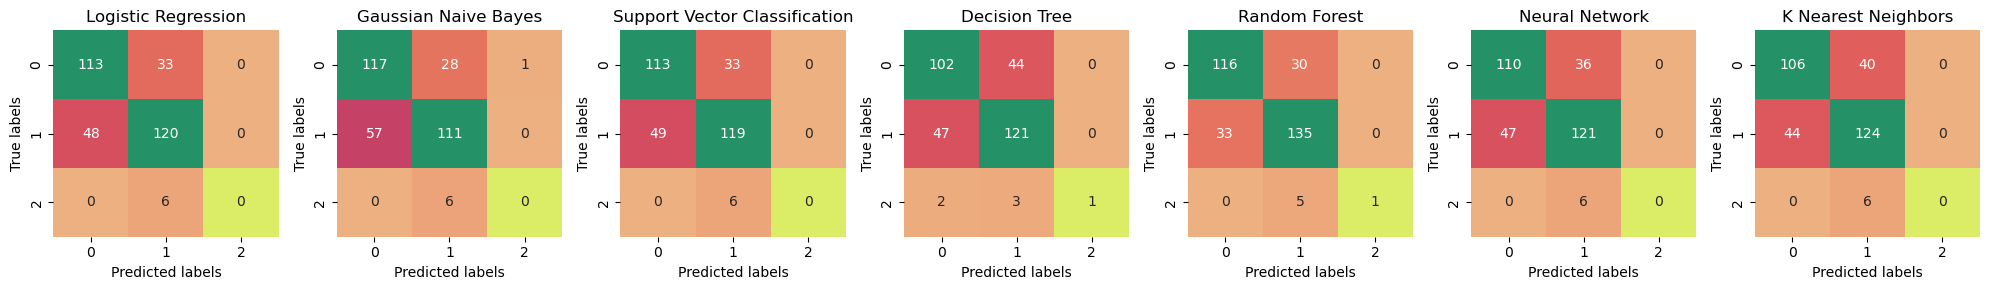

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest,78.75,99.92,79.09,78.75,78.35,0.58
1,Logistic Regression,72.81,72.24,71.65,72.81,72.12,0.47
2,Support Vector Classification,72.50,73.81,71.37,72.50,71.81,0.46
3,Neural Network,72.19,73.42,70.94,72.19,71.51,0.45
4,K Nearest Neighbors,71.88,78.89,70.54,71.88,71.20,0.45
5,Gaussian Naive Bayes,71.25,71.77,70.87,71.25,70.60,0.44
6,Decision Tree,70.00,99.92,70.51,70.00,69.69,0.41


None

In [37]:
results_df = model_accuracy_comparison(rw_features_train_scaled, rw_quality_train, rw_features_test_scaled, rw_quality_test)
display(results_df)

In [28]:
def model_cross_val(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Logistic Regression', LogisticRegression(max_iter=1000)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('Support Vector Classification', SVC()),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        ('K Nearest Neighbors', KNeighborsClassifier())
        
    ]

    cross_val_metrics_df = pd.DataFrame(columns=['Classifier', 'Mean Accuracy', 'Standard Deviation'])

    
    for name, clf in classifiers:

        # Perform 5-fold cross-validation
        scores = cross_val_score(clf, X_train, y_train, cv=5)

        # Calculate the mean and standard deviation of the scores
        mean_score = scores.mean().round(3)
        std_dev = scores.std().round(3)

        cross_val_metrics_row = {
            'Classifier': name,
            'Mean Accuracy': mean_score,
            'Standard Deviation': std_dev
        }

        cross_val_metrics_df = pd.concat([cross_val_metrics_df, pd.DataFrame([cross_val_metrics_row])]).reset_index(drop=True)
        cross_val_metrics_df = cross_val_metrics_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
    
    return cross_val_metrics_df

In [29]:
model_cross_val_df = model_cross_val(rw_features_train_scaled, rw_quality_train, rw_features_test_scaled, rw_quality_test)
display(model_cross_val_df)

,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest,0.776,0.026
1,Logistic Regression,0.722,0.015
2,Support Vector Classification,0.721,0.012
3,Decision Tree,0.719,0.017
4,Gaussian Naive Bayes,0.710,0.018
5,Neural Network,0.701,0.023
6,K Nearest Neighbors,0.701,0.018


c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics

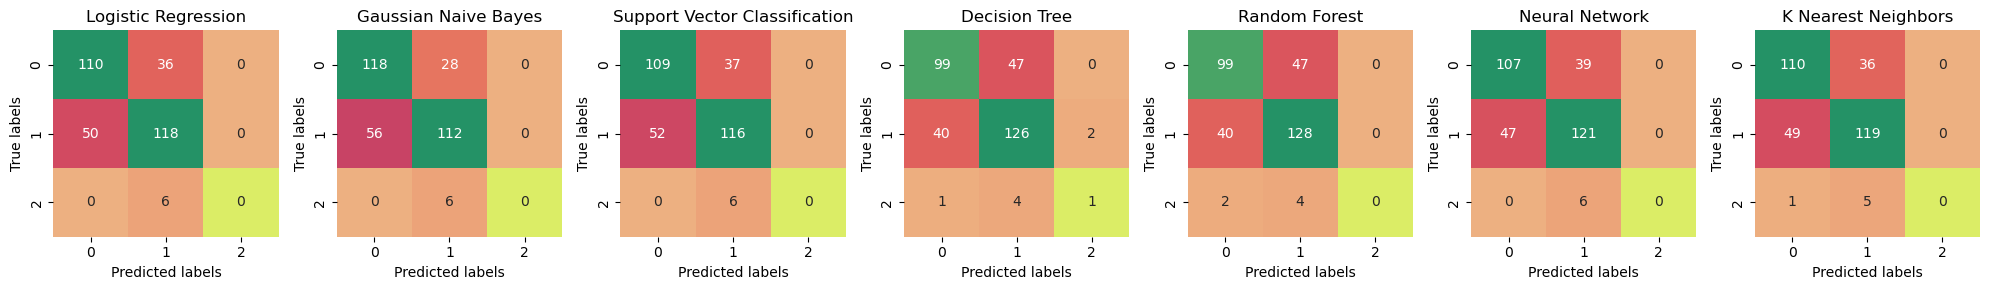

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Gaussian Naive Bayes,71.88,71.70,71.22,71.88,71.10,0.45
1,K Nearest Neighbors,71.56,79.05,70.41,71.56,70.90,0.44
2,Logistic Regression,71.25,72.71,70.09,71.25,70.58,0.44
3,Neural Network,71.25,72.56,69.97,71.25,70.58,0.43
4,Random Forest,70.94,93.04,69.58,70.94,70.21,0.42
5,Decision Tree,70.62,93.04,70.26,70.62,70.35,0.42
6,Support Vector Classification,70.31,72.56,69.19,70.31,69.65,0.42


None

,Classifier,Mean Accuracy,Standard Deviation
0,Logistic Regression,0.726,0.018
1,Random Forest,0.722,0.017
2,Support Vector Classification,0.719,0.011
3,Neural Network,0.719,0.033
4,Gaussian Naive Bayes,0.717,0.011
5,K Nearest Neighbors,0.711,0.017
6,Decision Tree,0.695,0.020


In [39]:
# Select features
rw_select2 = rw[['alcohol', 'volatile acidity']]
# Split data
rw_features_train2, rw_features_test2, rw_quality_train2, rw_quality_test2 = train_test_split(rw_select2,y_rw_quality,test_size=0.2, random_state=19)
# Scale features
scaler = StandardScaler()
rw_features_train_scaled2 = scaler.fit_transform(rw_features_train2)
rw_features_test_scaled2 = scaler.transform(rw_features_test2)

# Call our two previously defined functions
results_df2 = model_accuracy_comparison(rw_features_train_scaled2, rw_quality_train2, rw_features_test_scaled2, rw_quality_test2)
display(results_df2)
model_cross_val_df2 = model_cross_val(rw_features_train_scaled2, rw_quality_train2, rw_features_test_scaled2, rw_quality_test2)
display(model_cross_val_df2)

## &uarr; Only training on alcohol and volatile acid on RW leads to lower accuracy 

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics

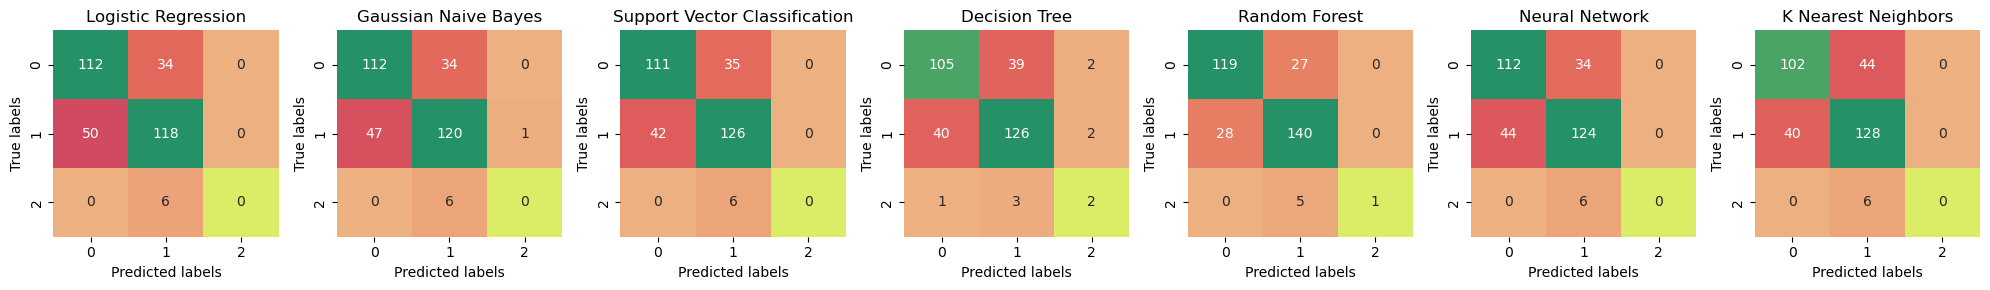

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest,81.25,100.00,81.54,81.25,80.83,0.63
1,Support Vector Classification,74.06,78.26,72.71,74.06,73.37,0.49
2,Neural Network,73.75,75.92,72.45,73.75,73.06,0.48
3,Decision Tree,72.81,100.00,72.81,72.81,72.81,0.47
4,Gaussian Naive Bayes,72.50,70.99,71.51,72.50,71.92,0.46
5,Logistic Regression,71.88,73.96,70.75,71.88,71.19,0.45
6,K Nearest Neighbors,71.88,79.98,70.53,71.88,71.16,0.44


None

,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest,0.792,0.020
1,Support Vector Classification,0.751,0.016
2,Neural Network,0.741,0.011
3,Logistic Regression,0.737,0.022
4,Decision Tree,0.717,0.018
5,Gaussian Naive Bayes,0.694,0.032
6,K Nearest Neighbors,0.694,0.028


In [38]:
# Select ALL features
rw_select3 = rw.drop(['encoded_quality_label'], axis=1)
# Split data
rw_features_train3, rw_features_test3, rw_quality_train3, rw_quality_test3 = train_test_split(rw_select3,y_rw_quality,test_size=0.2, random_state=19)
# Scale features
scaler = StandardScaler()
rw_features_train_scaled3 = scaler.fit_transform(rw_features_train3)
rw_features_test_scaled3 = scaler.transform(rw_features_test3)

# Call our two previously defined functions
results_df3 = model_accuracy_comparison(rw_features_train_scaled3, rw_quality_train3, rw_features_test_scaled3, rw_quality_test3)
display(results_df3)
model_cross_val_df3 = model_cross_val(rw_features_train_scaled3, rw_quality_train3, rw_features_test_scaled3, rw_quality_test3)
display(model_cross_val_df3)